<a name="intro"></a>

# Notebook 6: Análisis Comparativo y Visualización de Resultados

## Introducción

Bienvenidos al cuaderno final de nuestra serie, donde reunimos las perspectivas y resultados de los cinco cuadernos anteriores. Cada cuaderno ha aplicado una técnica de modelado diferente al conjunto de datos de la bomba de agua, incluyendo Redes Neuronales Artificiales, Regresión de Mínimos Cuadrados Parciales, Vecinos Más Cercanos (K-Nearest Neighbors), Random Forest y nuestro algoritmo personalizado AR-FL.

En este cuaderno, cargaremos los resultados generados por cada modelo y realizaremos un análisis comparativo. Visualizaremos las métricas de rendimiento una al lado de la otra para entender las fortalezas y debilidades de cada enfoque. Nuestro objetivo es sintetizar los hallazgos y proporcionar recomendaciones sobre la técnica de modelado más adecuada para predecir el rendimiento del sistema de bomba de agua en estudio.

<a name="indice"></a>
# Índice

*   [Introducción](#intro)

*   [Libraries](#librerias)

*   [Preparación de los datos](#readingdata)

  - [Carga del conjunto de datos](#cargardatos)
  - [Conjuntos de entrenamiento y prueba](#limpiardatos)  

*   [Modelo de ANN](#modeloredes)

  - [Definición del modelo](#definicionmodelos)
  - [Entrenamiento del modelo](#entrenamientomodelos)
  - [Evaluación del modelo](#evaluacionmodelos)
  - [Importancia de las variables (SHAP)](#importanciavariables)

*   [Guardando los resultados](#guardar)

<a name="librerias"></a>

## Librerias

[Numpy](https://es.wikipedia.org/wiki/NumPy) es un paquete fundamental para la computación científica en Python, que proporciona soporte para matrices y arreglos multidimensionales de gran tamaño, junto con una colección de funciones matemáticas para operar eficientemente en estos arreglos.

[Pandas](https://es.wikipedia.org/wiki/Pandas_(software)) es una biblioteca que ofrece estructuras de datos y herramientas de análisis de datos de alto rendimiento y fáciles de usar para Python. Su estructura de datos principal es el DataFrame, que permite almacenar y manipular datos tabulares en filas de observaciones y columnas de variables.

[Matplotlib](https://es.wikipedia.org/wiki/Matplotlib) es una biblioteca de trazado de gráficos para Python y su extensión matemática numérica, NumPy. Proporciona una API orientada a objetos para incrustar gráficos en aplicaciones utilizando herramientas de interfaz gráfica de usuario de propósito general como Tkinter, wxPython, Qt o GTK.

Google Colab es un servicio en la nube gratuito basado en Jupyter Notebooks que admite GPU gratuitas e integra con Google Drive. Se utiliza para la educación e investigación en aprendizaje automático, proporcionando un entorno fácil de usar para escribir y ejecutar código Python, lo cual es especialmente beneficioso para proyectos colaborativos.

In [ ]:
# Librerias generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Libreria para el uso de archivos
from google.colab import drive

In [ ]:
import matplotlib as mpl

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation = -90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    #plt.rcParams.update({'font.size': 15})

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)



    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
# Donde están los ficheros con las importancias de las componentes
#    Directorios comunes para todos
PROJECT_FOLDER   = "/content/drive/My Drive/Colab Notebooks/"
RESULT_FOLDER    = PROJECT_FOLDER + "Resultados/"
#     AF-RL
AFRL_FOLDER      = RESULT_FOLDER + "AF-RL/"
AFRL_FILENAME    = "Importancia_Balanceados_500.txt"
#     ANN
ANN_FOLDER       = RESULT_FOLDER + "ANN/"
ANN_FILENAME     = "ANN_SHAPS_500.csv"
#     PLS
PLS_FOLDER       = RESULT_FOLDER + "PLS/"
PLS_FILENAME     = "PLS_Importancias_500.csv"
#     KNN
KNN_FOLDER       = RESULT_FOLDER + "KNN/"
KNN_FILENAME     = "KNN_SHAP_500.csv"
#     RF
RF_FOLDER        = RESULT_FOLDER + "RF/"
RF_MDI_FILENAME  = "RF_MDI_500.csv"
RF_SHAP_FILENAME = "RF_SHAP_500.csv"


# Montar el disco de drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Leemos los datos de los ficheros con los pesos para cada columna que luego
# guardaremos en un dataframe

# Los sensores 15 y 50 ya están eliminados en cada caso
# Siempre se utilizan las medias absolutas para comparar

# AFRL
pesosAFRL = pd.read_csv( AFRL_FOLDER + AFRL_FILENAME, sep = ",", header=None, index_col=False)
pesosAFRL = pesosAFRL.astype(float)
# ANN
pesosANN = pd.read_csv( ANN_FOLDER + ANN_FILENAME, sep = ",", index_col=False)
pesosANN = pesosANN['AbsMeans'].astype(float)
# PLS
pesosPLS = pd.read_csv( PLS_FOLDER + PLS_FILENAME, sep = ",", index_col=False)
pesosPLS = pesosPLS['AbsMeans'].astype(float)
# KNN
pesosKNN = pd.read_csv( KNN_FOLDER + KNN_FILENAME, sep = ",", index_col=False)
pesosKNN = pesosKNN['AbsMeans'].astype(float)
# RF
pesosRFM = pd.read_csv( RF_FOLDER + RF_MDI_FILENAME,  sep = ",", index_col=False)
pesosRFS = pd.read_csv( RF_FOLDER + RF_SHAP_FILENAME, sep = ",", index_col=False)
pesosRFM = pesosRFM['AbsMeans'].astype(float)
pesosRFS = pesosRFS['AbsMeans'].astype(float)

# Hay que transformar los números en valor absoluto y normalizarlo entre 0 y 1
pesosAFRL = np.abs(pesosAFRL)
pesosAFRL = pesosAFRL/pesosAFRL.max()

pesosANN = np.abs(pesosANN)
pesosANN = pesosANN/pesosANN.max()

pesosPLS = np.abs(pesosPLS)
pesosPLS = pesosPLS/pesosPLS.max()

pesosKNN = np.abs(pesosKNN)
pesosKNN = pesosKNN/pesosKNN.max()

pesosRFM = np.abs(pesosRFM)
pesosRFM = pesosRFM/pesosRFM.max()

pesosRFS = np.abs(pesosRFS)
pesosRFS = pesosRFS/pesosRFS.max()

In [ ]:
# Guardamos el ID de cada sensor; notice that ID 15 is not in the list
sensorNames = ["SENSOR_00", "SENSOR_01", "SENSOR_02", "SENSOR_03", "SENSOR_04",
               "SENSOR_05", "SENSOR_06", "SENSOR_07", "SENSOR_08", "SENSOR_09",
               "SENSOR_10", "SENSOR_11", "SENSOR_12", "SENSOR_13", "SENSOR_14",
               "SENSOR_16", "SENSOR_17", "SENSOR_18", "SENSOR_19", "SENSOR_20",
               "SENSOR_21", "SENSOR_22", "SENSOR_23", "SENSOR_24", "SENSOR_25",
               "SENSOR_26", "SENSOR_27", "SENSOR_28", "SENSOR_29", "SENSOR_30",
               "SENSOR_31", "SENSOR_32", "SENSOR_33", "SENSOR_34", "SENSOR_35",
               "SENSOR_36", "SENSOR_37", "SENSOR_38", "SENSOR_39", "SENSOR_40",
               "SENSOR_41", "SENSOR_42", "SENSOR_43", "SENSOR_44", "SENSOR_45",
               "SENSOR_46", "SENSOR_47", "SENSOR_48", "SENSOR_49", "SENSOR_50",
               "SENSOR_51"]

# Guardamos el significado de cada sensor
sensorProperties = ["Motor Casing Vibration", "Motor Frequency A",
                    "Motor Frequency B", "Motor Frequency C", "Motor Speed",
                    "Motor Current", "Motor Active Power",
                    "Motor Apparent Power", "Motor Reactive Power",
                    "Motor Shaft Power", "Motor Phase Current A",
                    "Motor Phase Current B", "Motor Phase Current C",
                    "Motor Coupling Vibration", "Motor Phase Voltage AB",
                    "Motor Phase Voltage BC", "Motor Phase Voltage CA",
                    "Pump Casing Vibration", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                    "Pump Stage 1 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                    "Pump Inlet Flow", "Pump Discharge Flow", "Pump UNKNOWN",
                    "Pump Lube Oil Overhead Reservoir Level",
                    "Pump Lube Oil Return Temp", "Pump Lube Oil Supply Temp",
                    "Pump Thrust Bearing Active Temp",
                    "Motor Non Drive End Radial Bearing Temp 1",
                    "Motor Non Drive End Radial Bearing Temp 2",
                    "Pump Thrust Bearing Inactive Temp",
                    "Pump Drive End Radial Bearing Temp 1",
                    "Pump non Drive End Radial Bearing Temp 1",
                    "Pump Non Drive End Radial Bearing Temp 2",
                    "Pump Drive End Radial Bearing Temp 2",
                    "Pump Inlet Pressure", "Pump Temp Unknown",
                    "Pump Discharge Pressure 1", "Pump Discharge Pressure 2"]

# Recordamos que eliminamos los datos de los sensores 15 y 50. Así que
# procedemos a eliminar también los nombres de estas listas
#
# Pero el sensor 15, NO ESTÁ EN LA LISTA.
# Sólo quitamos el 50, que corresponde con la posición 49 (vaya lío)
del sensorProperties[49]
del sensorNames[49]

In [ ]:
# Creamos el dataframe vacío donde guardamos las predicciones de cada modelo.
#
# El orden será
# ---- ANN
# ---- KNN
# ---- Random Forest (SHAP)
# ---- Random Forest (MDI)
# ---- PLS
# ---- AF-RL
shapAverageData    = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))
shapSigmaData      = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))
shapAbsAverageData = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))
shapAbsSigmaData   = pd.DataFrame(0, index=range( len(sensorNames) ), columns=range(6))


shapAverageData    = shapAverageData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapSigmaData      = shapSigmaData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapAbsAverageData = shapAbsAverageData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapAbsSigmaData   = shapAbsSigmaData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)

In [ ]:
# Metemos los datos en el dataframe

# ---- 0 - ANN
shapAbsAverageData.iloc[:,0] = pesosANN

# ---- 1 - KNN
shapAbsAverageData.iloc[:,1] = pesosKNN

# ---- 2 - RF SHAP
shapAbsAverageData.iloc[:,2] = pesosRFS

# ---- 3 - RF MDI
shapAbsAverageData.iloc[:,3] = pesosRFM

# ---- 4 - PLS
shapAbsAverageData.iloc[:,4] = pesosPLS

# ---- 5 - AF-RL

# Creamos un vector donde almacenamos los valores de importancia
vectorMedias    = np.zeros(50)
vectorAbsMedias = pesosAFRL
vectorSigmas    = np.zeros(50)
vectorAbsSigmas = np.zeros(50)

# Lo metemos todo en la tabla final
shapAverageData.iloc[:,5]    = vectorMedias
shapSigmaData.iloc[:,5]      = vectorSigmas
shapAbsAverageData.iloc[:,5] = vectorAbsMedias
shapAbsSigmaData.iloc[:,5]   = vectorAbsSigmas

<ipython-input-20-959da379ea9d>:27: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  shapAverageData.iloc[:,5]    = vectorMedias
<ipython-input-20-959da379ea9d>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  shapSigmaData.iloc[:,5]      = vectorSigmas
<ipython-input-20-959da379ea9d>:30: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(

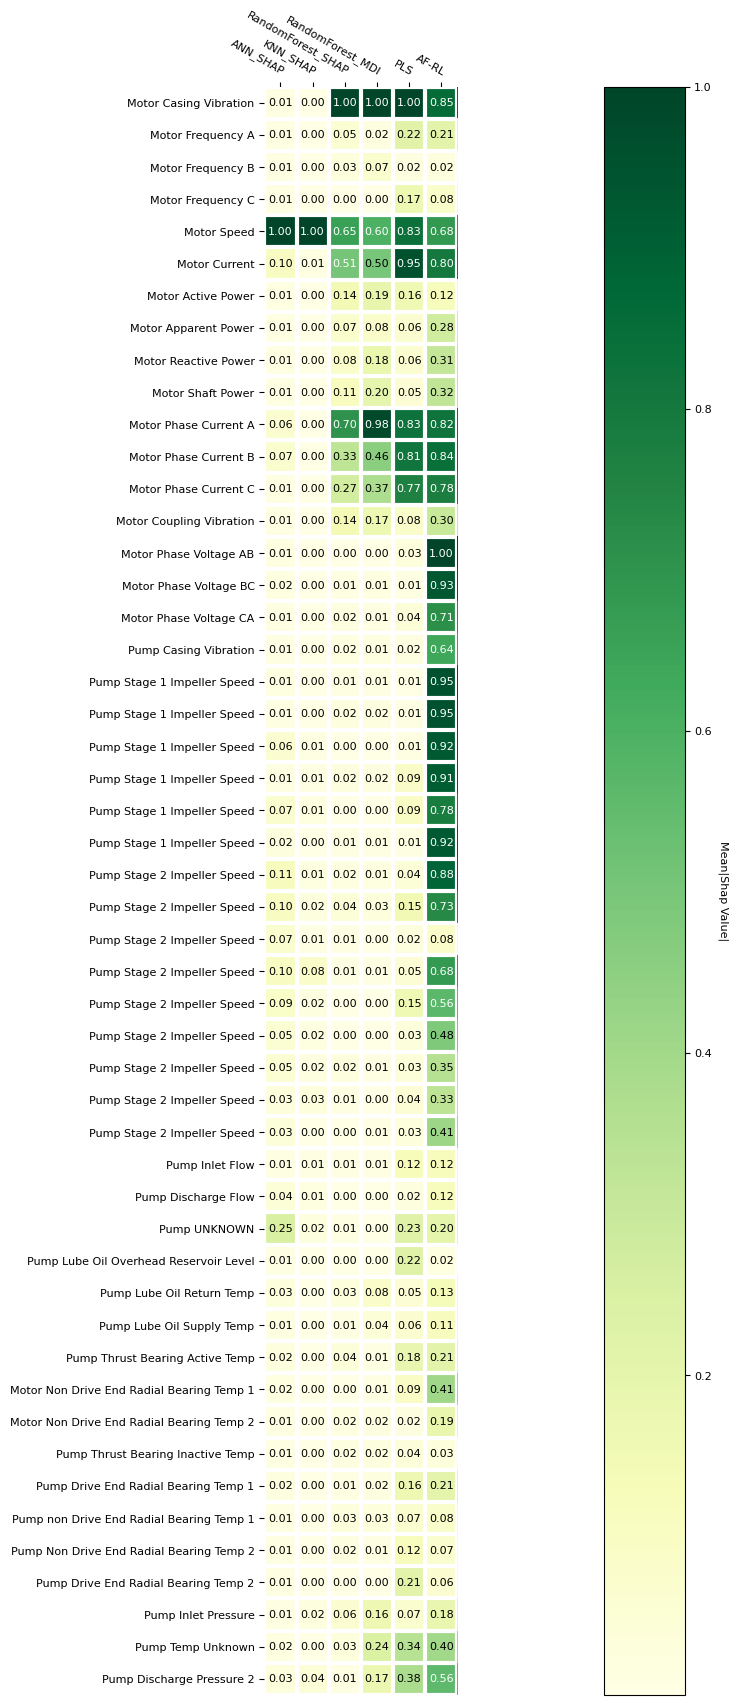

In [ ]:
# ----------------------------------
# OJO!
# No encuentro el fallo, pero la primera vez que se ejecuta este código, el
# gráfico sale bastante feo, pero si lo vuelves a ejecutar una segunda vez
# sale mucho mejor :-S
# ----------------------------------


# Show the SHAP heatmaps

# ----------------------------------
# Absolute
# ----------------------------------

# Prepare the data to do a heatmap of the normalzed SHAP values
heatmapDF = shapAbsAverageData.copy()

# Datos del heatmap
a = heatmapDF.to_numpy().astype(float)

# Nombre de cada una de las filas (sensores)
b = sensorProperties

# Nombre de las columnas
c = heatmapDF.columns.values.tolist()


fig, ax = plt.subplots()

im, cbar = heatmap(a, b, c, ax=ax, cmap="YlGn", cbarlabel="Mean|Shap Value|")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
fig.set_size_inches(30.5, 20.5)
plt.rcParams.update({'font.size': 8})
plt.show()